## Example of ML-Insights on Mortality Model Using MIMIC ICU Data*

We develop a few models for predicting mortality in the ICU based on labs and vital signs in the first 24 hours of entry to the ICU.  We then use the `ml_insights` package to visualize the effects of the different features in the model, and to be able to explain the main factors that contributed to a patient being high or low risk.

*MIMIC-III, a freely accessible critical care database. Johnson AEW, Pollard TJ, Shen L, Lehman L, Feng M, Ghassemi M, Moody B, Szolovits P, Celi LA, and Mark RG. Scientific Data (2016).
https://mimic.physionet.org


In [1]:
# "pip install ml_insights" in terminal if needed

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ml_insights as mli
%matplotlib inline

from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score

In [2]:
# Load dataset derived from the MMIC database

lab_aug_df = pd.read_csv("data/lab_vital_icu_table.csv")

In [3]:
lab_aug_df.head(10)

,subject_id,hadm_id,icustay_id,aniongap_min,aniongap_max,albumin_min,albumin_max,bicarbonate_min,bicarbonate_max,bilirubin_min,...,meanbp_mean,resprate_min,resprate_max,resprate_mean,tempc_min,tempc_max,tempc_mean,spo2_min,spo2_max,spo2_mean
0,9,150750,220597,13.0,13.0,NaN,NaN,26.0,30.0,0.4,...,98.850000,14.0,19.0,14.369565,35.500001,37.888887,37.049383,95.0,100.0,97.650000
1,13,143045,263738,10.0,14.0,3.9,3.9,23.0,24.0,0.4,...,93.772727,11.0,25.0,15.320000,35.944443,37.400002,36.653534,94.0,100.0,97.700000
2,20,157681,264490,12.0,12.0,NaN,NaN,21.0,21.0,NaN,...,75.058333,10.0,27.0,15.404762,35.900002,37.299999,36.545714,95.0,100.0,98.435897
3,28,162569,225559,13.0,13.0,NaN,NaN,23.0,23.0,NaN,...,69.133333,9.0,32.0,16.677419,35.900002,37.700001,37.033333,92.0,100.0,96.419355
4,37,188670,213503,9.0,10.0,NaN,NaN,33.0,35.0,NaN,...,73.297610,15.0,30.0,22.241379,36.833335,38.055556,37.333334,89.0,99.0,96.533333
5,71,111944,211832,13.0,30.0,3.6,4.7,17.0,26.0,0.4,...,79.222208,13.0,25.0,17.130435,35.722224,37.833332,37.351852,99.0,100.0,99.862069
6,72,156857,239612,18.0,18.0,NaN,NaN,20.0,20.0,3.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,78,100536,233150,9.0,9.0,2.7,3.1,26.0,26.0,0.8,...,121.129705,11.0,24.0,16.764706,36.333334,36.833335,36.577778,96.0,100.0,98.470588
8,88,123010,297289,13.0,18.0,NaN,NaN,19.0,26.0,NaN,...,91.884615,9.0,45.0,20.352941,35.722224,39.111112,37.810185,99.0,100.0,99.962963
9,95,160891,216431,13.0,17.0,NaN,NaN,23.0,26.0,NaN,...,93.952386,14.0,20.0,16.363636,35.722224,36.666667,36.305556,96.0,100.0,98.071429


In [4]:
X = lab_aug_df.loc[:,['aniongap_min', 'aniongap_max',
       'albumin_min', 'albumin_max', 'bicarbonate_min', 'bicarbonate_max',
       'bilirubin_min', 'bilirubin_max', 'creatinine_min', 'creatinine_max',
       'chloride_min', 'chloride_max', 
       'hematocrit_min', 'hematocrit_max', 'hemoglobin_min', 'hemoglobin_max',
       'lactate_min', 'lactate_max', 'platelet_min', 'platelet_max',
       'potassium_min', 'potassium_max', 'ptt_min', 'ptt_max', 'inr_min',
       'inr_max', 'pt_min', 'pt_max', 'sodium_min', 'sodium_max', 'bun_min',
       'bun_max', 'wbc_min', 'wbc_max','sysbp_max', 'sysbp_mean', 'diasbp_min', 'diasbp_max', 'diasbp_mean',
       'meanbp_min', 'meanbp_max', 'meanbp_mean', 'resprate_min',
       'resprate_max', 'resprate_mean', 'tempc_min', 'tempc_max', 'tempc_mean',
       'spo2_min', 'spo2_max', 'spo2_mean']]
y = lab_aug_df['hospital_expire_flag']

In [5]:
# Impute the median for in each column to replace NA's 

median_vec = [X.iloc[:,i].median() for i in range(len(X.columns))]

for i in range(len(X.columns)):
    X.iloc[:,i].fillna(median_vec[i],inplace=True)

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9942)

In [7]:
gbmodel1 = GradientBoostingClassifier(n_estimators = 1000, 
                                     learning_rate = .005,
                                    max_depth = 7)
gbmodel1.fit(X_train,y_train)

GradientBoostingClassifier(init=None, learning_rate=0.005, loss='deviance',
              max_depth=7, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=1000,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [8]:
test_res = np.round(gbmodel1.predict_proba(X_test),decimals=3)[:,1]


In [9]:
roc_auc_score(y_test,test_res)

0.86739162126025937

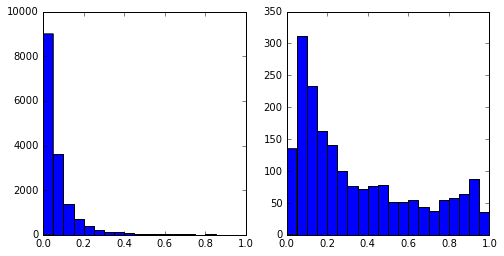

In [10]:
# Side by side histograms showing scores of positive vs negative cases

fig, ax = plt.subplots(1,2, figsize = (8,4))

ax[0].hist(test_res[np.where(y_test==0)],bins=20,range=[0,1]);
ax[1].hist(test_res[np.where(y_test==1)],bins=20,range=[0,1]);

In [11]:
mxr = mli.ModelXRay(gbmodel1, X_test.iloc[:500,:])

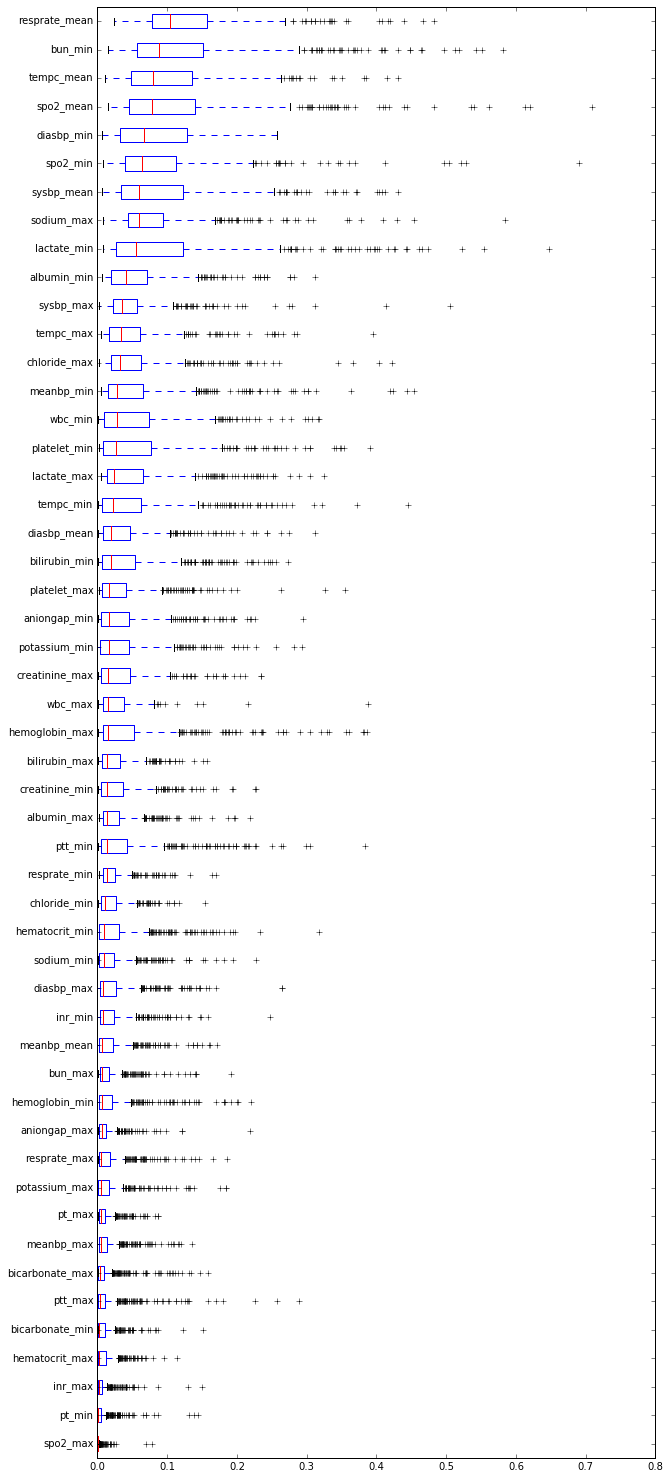

In [12]:
mxr.feature_effect_summary(num_features=55)

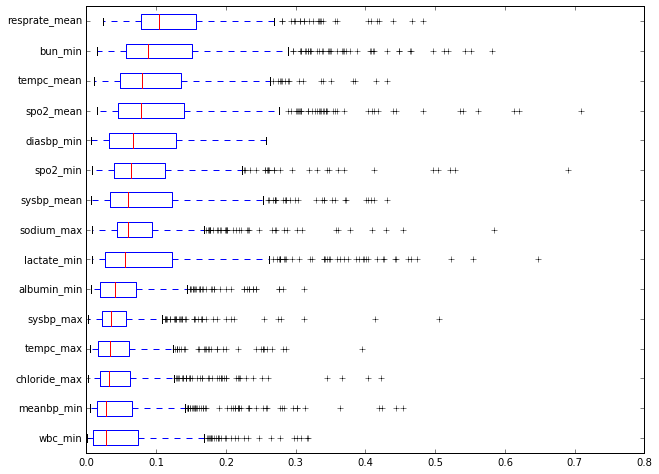

In [13]:
mxr.feature_effect_summary(num_features=15)

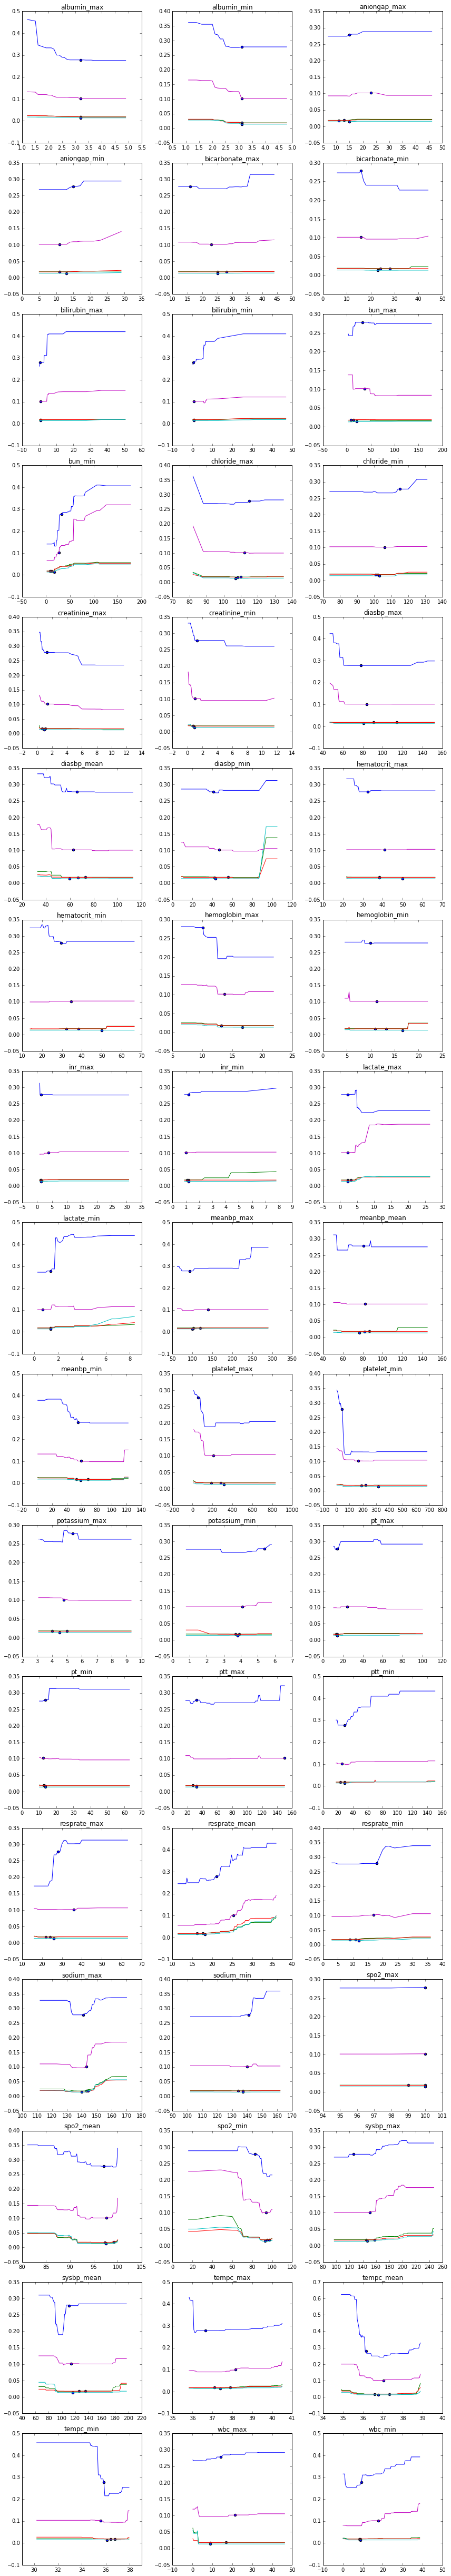

In [14]:
indices = mxr.feature_dependence_plots()

In [15]:
indices

array([220, 209, 165, 305, 266])

In [16]:
mxr.explain_prediction_difference(311,388,tol=.05)

Your initial point has a target value of 0.0253
Your final point has a target value of 0.1612
Changing sysbp_mean from 99.2143 to 79.2692
		changes your target by 0.0341 to 0.0594
----------
Changing resprate_mean from 19.3333 to 25.6071
		changes your target by 0.0694 to 0.1288
----------
Changing albumin_min from 3.1 to 2.4
		changes your target by 0.0658 to 0.1946
----------
Changing hemoglobin_min from 14.6 to 8.2
		changes your target by -0.0739 to 0.1207
----------
Changing pt_max from 13.1 to 20.9
		changes your target by 0.04 to 0.1607
----------
Tolerance of 0.05 reached
Current value of 0.1607 is within 5.0% of 0.1612


(['sysbp_mean', 'resprate_mean', 'albumin_min', 'hemoglobin_min', 'pt_max'],
 [(99.214285714285694, 79.269230769230788),
  (19.3333333333333, 25.607142857142897),
  (3.1000000000000001, 2.3999999999999999),
  (14.6, 8.1999999999999993),
  (13.1, 20.899999999999999)],
 [0.034119289828052249,
  0.069385792055777648,
  0.065842431703977855,
  -0.073896687378050524,
  0.04002153989867574],
 [0.025270186728347854,
  0.059389476556400103,
  0.12877526861217775,
  0.19461770031615561,
  0.12072101293810508,
  0.16074255283678082])

Now we do the same thing for a Random Forest Model

In [17]:
rfmodel1 = RandomForestClassifier(n_estimators = 500,class_weight='balanced')
rfmodel1.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=None, max_features='auto',
            max_leaf_nodes=None, min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [18]:
test_res_rf = np.round(rfmodel1.predict_proba(X_test),decimals=3)[:,1]

roc_auc_score(y_test,test_res_rf)

0.86709772206677294

In [19]:
mxr_rf = mli.ModelXRay(rfmodel1, X_test.iloc[:500,:])

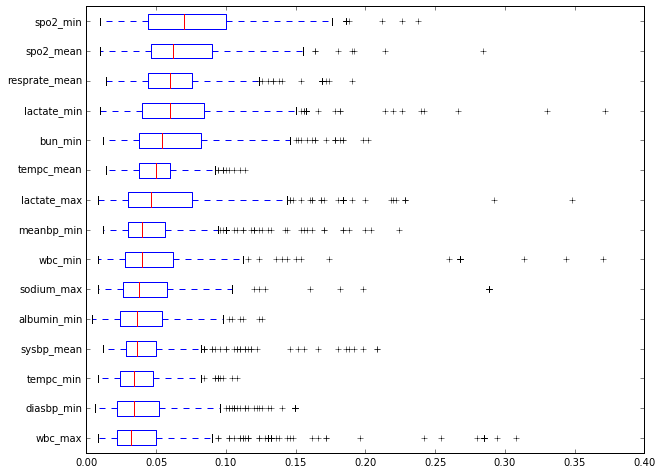

In [20]:
mxr_rf.feature_effect_summary(num_features=15)

In [21]:
indices

array([220, 209, 165, 305, 266])

array([220, 209, 165, 305, 266])

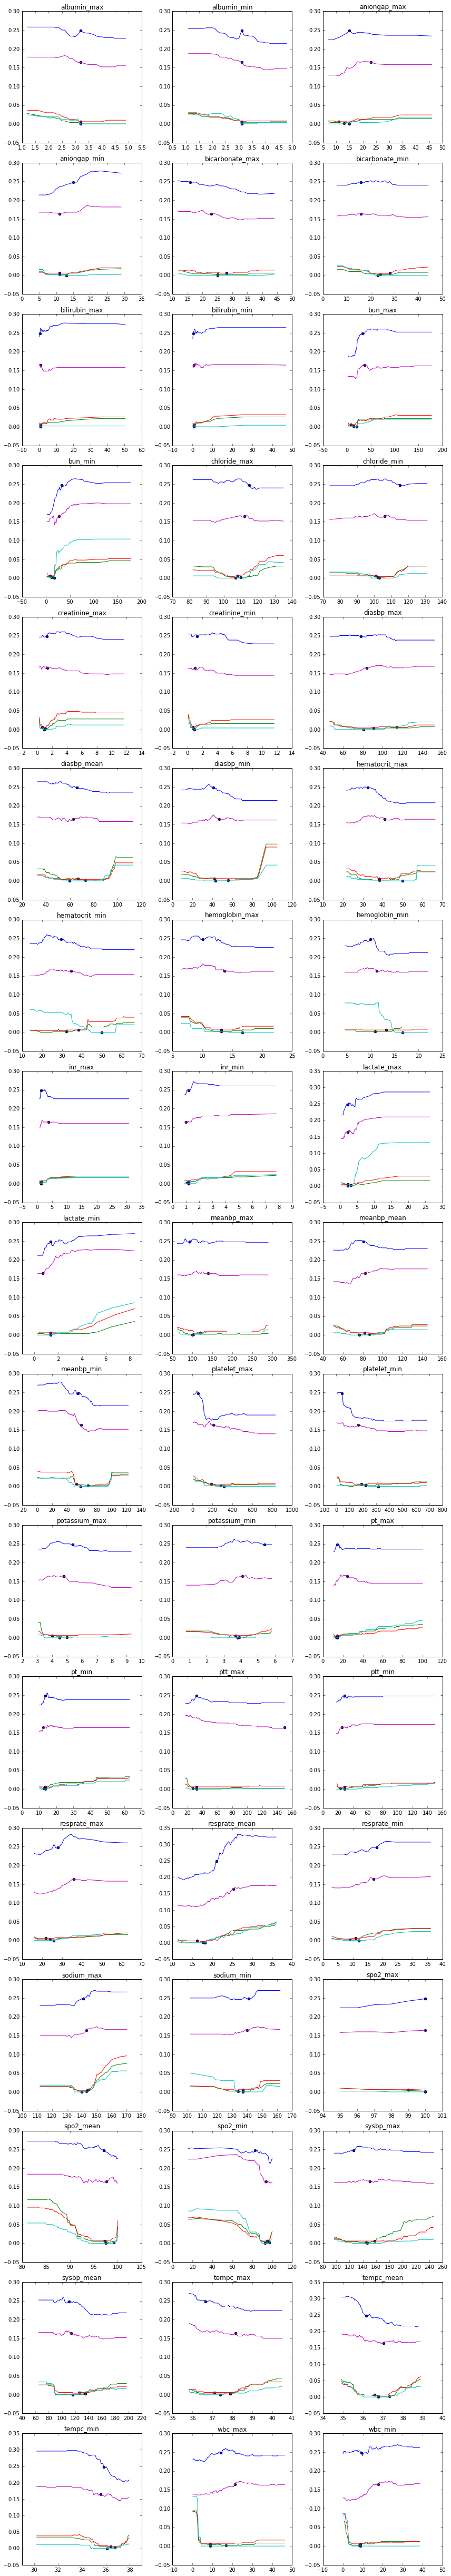

In [22]:
mxr_rf.feature_dependence_plots(pts_selected = indices)

In [23]:
mxr_rf.explain_prediction_difference(311,388, tol=.05)

Your initial point has a target value of 0.018
Your final point has a target value of 0.17
Changing sysbp_mean from 99.2143 to 79.2692
		changes your target by 0.036 to 0.054
----------
Changing albumin_min from 3.1 to 2.4
		changes your target by 0.028 to 0.082
----------
Changing bun_max from 16.0 to 24.0
		changes your target by 0.024 to 0.106
----------
Changing hemoglobin_min from 14.6 to 8.2
		changes your target by 0.02 to 0.126
----------
Changing resprate_max from 24.0 to 32.0
		changes your target by 0.018 to 0.144
----------
Changing albumin_max from 3.2 to 2.4
		changes your target by 0.02 to 0.164
----------
Tolerance of 0.05 reached
Current value of 0.164 is within 5.0% of 0.17


(['sysbp_mean',
  'albumin_min',
  'bun_max',
  'hemoglobin_min',
  'resprate_max',
  'albumin_max'],
 [(99.214285714285694, 79.269230769230788),
  (3.1000000000000001, 2.3999999999999999),
  (16.0, 24.0),
  (14.6, 8.1999999999999993),
  (24.0, 32.0),
  (3.2000000000000002, 2.3999999999999999)],
 [0.036000000000000004,
  0.028000000000000004,
  0.023999999999999994,
  0.020000000000000004,
  0.017999999999999988,
  0.020000000000000018],
 [0.017999999999999999,
  0.053999999999999999,
  0.082000000000000003,
  0.106,
  0.126,
  0.14399999999999999,
  0.16400000000000001])

Now do the same thing for XGBoost

In [24]:
import xgboost as xgb

In [25]:
xgb1 = xgb.XGBClassifier(max_depth=6, n_estimators=2000, learning_rate=0.005,objective = 'binary:logistic')
xgb1.fit(X_train, y_train)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.005, max_delta_step=0, max_depth=6,
       min_child_weight=1, missing=None, n_estimators=2000, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [26]:
test_res_xgb = np.round(xgb1.predict_proba(X_test),decimals=3)[:,1]

roc_auc_score(y_test,test_res_xgb)

0.87477739833310675

In [27]:
mxr_xgb = mli.ModelXRay(xgb1, X_test.iloc[:500,:])

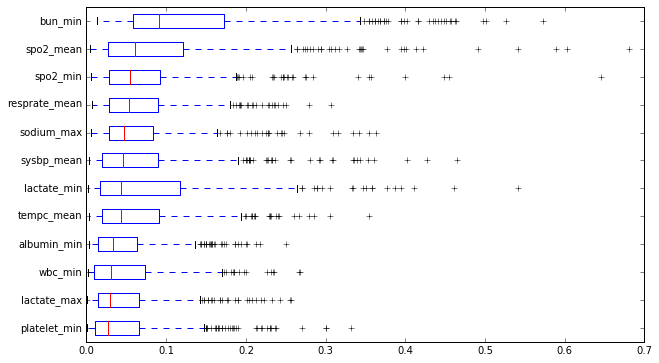

In [28]:
mxr_xgb.feature_effect_summary(num_features=12)

array([220, 209, 165, 305, 266])

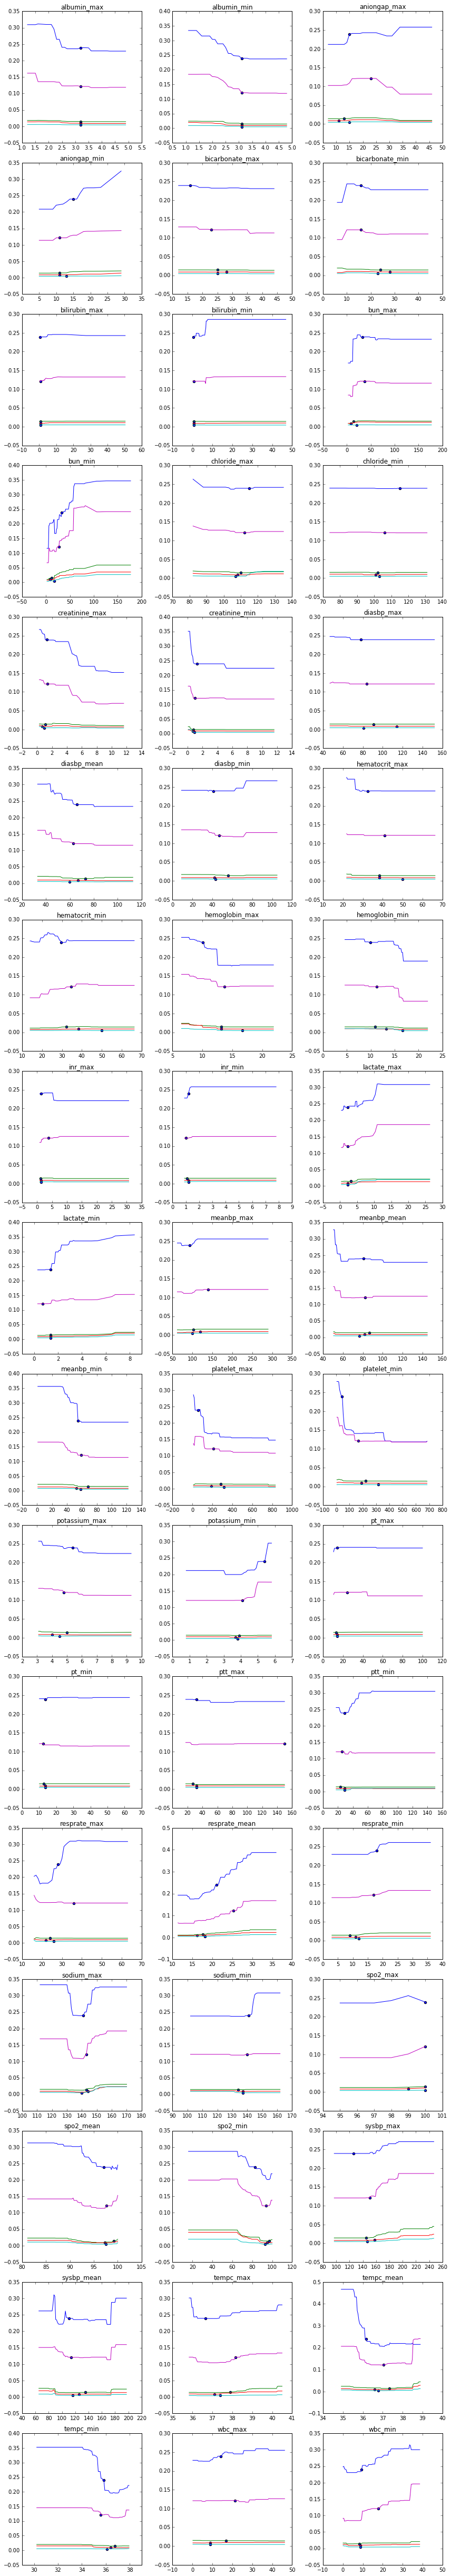

In [29]:
mxr_xgb.feature_dependence_plots(pts_selected = indices)

In [30]:
#The explain_prediction_difference function does not currently work with XGBoost.  Will be fixed soon.

#mxr_xgb.explain_prediction_difference(229,170, tol=.05)